In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import glob
import random
from tqdm import tqdm
from tqdm import trange
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import precision_score, recall_score, f1_score
import wandb
wandb.init(project = "HC Assignment2")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ahmed-sharshar. Use `wandb login --relogin` to force relogin


In [2]:
!pip install ptflops
!pip install thop

/bin/bash: pip: command not found
/bin/bash: pip: command not found


In [2]:
import random, os

##Added, Model Reproducibility
# Set the random seed to ensure reproducibility
seed = 42 
# Set the random seed for the Python interpreter
random.seed(seed)
# Set the random seed for hash values used in Python dictionaries
os.environ['PYTHONHASHSEED'] = str(seed)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed for PyTorch on CPU
torch.manual_seed(seed)
# Set the random seed for PyTorch on GPU (CUDA)
torch.cuda.manual_seed(seed)
# Set the flag to ensure that the computations on GPU are deterministic
torch.backends.cudnn.deterministic = True
# Set the flag to disable the automatic selection of the fastest algorithm for GPU computations
torch.backends.cudnn.benchmark = False

In [3]:
dirlist = ['TBX11K/imgs/health', 'TBX11K/imgs/tb']
classes = ['Healthy', 'tb']
filepaths = []
labels = []
for d, c in zip(dirlist, classes):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join(d, f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  4600    labels:  4600


In [4]:
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
df=pd.DataFrame(np.array(df).reshape(4600,2), columns = ['file_paths', 'labels'])
print(df['labels'].value_counts())

Healthy    3800
tb          800
Name: labels, dtype: int64


In [5]:
h_df = df[df['labels'] == 'Healthy']
h_df = h_df.sort_values('file_paths')

tb_df = df[df['labels'] == 'tb']
tb_df = tb_df.sort_values('file_paths')

In [6]:
h_indix = int ( len(h_df.index) * 0.2)
tb_indix  = int ( len(tb_df.index) * 0.2)

In [7]:
h_test = h_df.iloc[0:h_indix]
h_train =  h_df.iloc[h_indix  :]

tb_test = tb_df.iloc[0:tb_indix]
tb_train =  tb_df.iloc[tb_indix  :]

In [8]:
train_df = pd.concat([h_train, tb_train])
test_df = pd.concat([h_test, tb_test])

In [9]:
train_df['file_paths'].iloc[0]

'TBX11K/imgs/health/h0995.png'

In [10]:
X_train = train_df['file_paths']
X_test = test_df['file_paths']

Y_train = train_df['labels']
Y_test = test_df['labels']

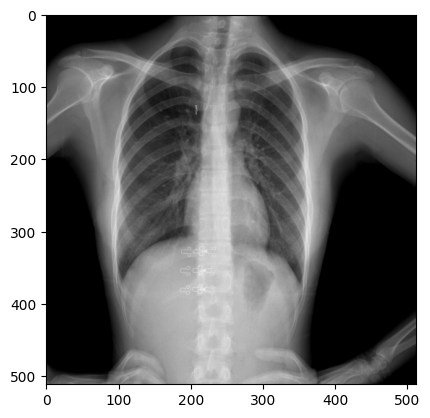

In [11]:
img = df.loc[1,"file_paths"]
img = plt.imread(img)
plt.imshow(img)

In [12]:
print(img.max())

0.94509804


In [13]:
import torch
from torchvision import transforms
from PIL import Image
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

# Load the dataframe
train_df = train_df

# Define the transformations
tb_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Define the transformations
healthy_transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load the images and labels
images = []
labels = []

for i in range(len(train_df)):
    # Load the image
    image = Image.open(train_df['file_paths'].iloc[i])


    # Load and convert the label to tensor
    label_str = train_df['labels'].iloc[i]
    if label_str == 'Healthy':
        label = torch.tensor(0)
        # Apply the transformations
        image = tb_transformations(image)
        # Append the image to the list
        images.append(image)
        
    elif label_str == 'tb':
        label = torch.tensor(1)
        # Apply the transformations
        image = tb_transformations(image)
        # Append the image to the list
        images.append(image)
    else:
        label = torch.tensor(-1)  # For unknown labels
    labels.append(label)

# Convert the images and labels to tensors
images = torch.stack(images)
labels = torch.stack(labels)

print(images.shape)
print(labels.shape)

dataset = TensorDataset(images, labels)

# Create a DataLoader
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

torch.Size([3680, 3, 224, 224])
torch.Size([3680])


In [14]:
import torch
from torchvision import transforms
from PIL import Image
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

# Load the dataframe
train_df = test_df


# Define the transformations
healthy_transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the images and labels
images = []
labels = []

for i in range(len(train_df)):
    # Load the image
    image = Image.open(train_df['file_paths'].iloc[i])

    # Load and convert the label to tensor
    label_str = train_df['labels'].iloc[i]
    if label_str == 'Healthy':
        label = torch.tensor(0)
        # Apply the transformations
        image = healthy_transformations(image)
        # Append the image to the list
        images.append(image)
        
    elif label_str == 'tb':
        label = torch.tensor(1)
        # Apply the transformations
        image = healthy_transformations(image)
        # Append the image to the list
        images.append(image)
    else:
        label = torch.tensor(-1)  # For unknown labels
    labels.append(label)

# Convert the images and labels to tensors
images = torch.stack(images)
labels = torch.stack(labels)

print(images.shape)
print(labels.shape)

dataset = TensorDataset(images, labels)

# Create a DataLoader
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=False)

torch.Size([920, 3, 224, 224])
torch.Size([920])


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [16]:
def calculate_f1_score(targets, preds):
    targets = targets.cpu().numpy()
    preds = preds.cpu().numpy()
    f1_scores = {}
    for cls in range(2):
        precision = precision_score(targets == cls, preds == cls)
        recall = recall_score(targets == cls, preds == cls)
        f1 = 2 * precision * recall / (precision + recall)
        f1_scores[cls] = {"precision": precision, "recall": recall, "f1": f1}
    return f1_scores


In [19]:
import torch.nn.functional as F

def train(model):
    model.train()
    train_loss = 0
    total = 0
    correct = 0
    all_preds = []
    all_targets = []
    alpha = 0.25
    gamma = 2
    # compute class weights
    class_weights = torch.Tensor([1/5, 1]).to(device)

    # set weights for loss function
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

    with tqdm(train_dataloader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            # send to device
            data, target = data.to(device), target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # calculate the loss with Focal Loss
            pt = F.softmax(output, dim=1)
            loss = -alpha*(1-pt)**gamma*torch.log(pt+1e-10)
            loss = loss.gather(1, target.view(-1, 1)).squeeze()
            loss = loss.mean()

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update running training loss
            train_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            all_preds.append(predicted)
            all_targets.append(target)

            wandb.log({'training_loss':train_loss/(batch_idx+1) , 'training_accuracy' :  100.*correct/total}, step=epoch)

        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        f1_scores = calculate_f1_score(all_targets, all_preds)
        for cls, score_dict in f1_scores.items():
            print("F1 score for class {}: {:.4f}".format(cls, score_dict['f1']))

        print(' train loss: {:.4f} accuracy: {:.4f}'.format(train_loss/(batch_idx+1), 100.*correct/total))


In [18]:
def validate(model):   
    model.eval()

    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with tqdm(test_dataloader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            # send to device
            data, target = data.to(device), target.to(device)
    
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            all_preds.append(predicted)
            all_targets.append(target)
            wandb.log({'test_loss':test_loss/(batch_idx+1) , 'test_accuracy' :  100.*correct/total}, step=epoch) 
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        f1_scores = calculate_f1_score(all_targets, all_preds)
        for cls, score_dict in f1_scores.items():
            print("F1 score for class {}: {:.4f}".format(cls, score_dict['f1']))

        print(' test loss: {:.4f} accuracy: {:.4f}'.format(test_loss/(batch_idx+1), 100.*correct/total))

In [20]:
import timm
#efficientnet_lite0
model = timm.create_model('efficientnet_lite0', num_classes=2, drop_rate = 0.7 , pretrained=True)

In [21]:
sum(p.numel() for p in  model.parameters())

3373570

In [22]:
import torch
import torchvision.models as models
from ptflops import get_model_complexity_info


# Specify the input tensor shape
input_shape = ( 3, 224, 224)

# Count the number of FLOPs for the model
flops_count, params_count = get_model_complexity_info(model, input_shape, print_per_layer_stat=False)

# Print the number of FLOPs and parameters for the model
print(f"Number of FLOPs: {flops_count}")
print(f"Number of parameters: {params_count}")


Number of FLOPs: 390.13 MMac
Number of parameters: 3.37 M


In [23]:
import torch
from thop import profile

model = model
#input_shape = (1, 3, 224, 224)
#input = torch.randn(*input_shape)
input = images

flops, params = profile(model, inputs=(input, ))
print(f"FLOPs: {flops}")


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 353256183040.0


In [24]:
model.cuda()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedR

In [25]:
#criterion = nn.CrossEntropyLoss()
# set weights for loss function


optimizer = optim.Adam(model.parameters(), lr=1e-5)
scedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=2, threshold=0.001, threshold_mode='abs')


epochs = 30

start = time.time()
for epoch in range(0, epochs):
    print("epoch number: {0}".format(epoch))
    train(model)
    validate(model)
    
end = time.time()
Total_time=end-start
print('Total training and inference time is: {0}'.format(Total_time))

epoch number: 0


100%|██████████| 115/115 [00:19<00:00,  5.85batch/s]


F1 score for class 0: 0.6518
F1 score for class 1: 0.2957
 train loss: 29.4724 accuracy: 53.3967


100%|██████████| 29/29 [00:01<00:00, 19.18batch/s]


F1 score for class 0: 0.7264
F1 score for class 1: 0.4655
 test loss: 1.5654 accuracy: 63.8043
epoch number: 1


100%|██████████| 115/115 [00:16<00:00,  6.80batch/s]


F1 score for class 0: 0.7279
F1 score for class 1: 0.3740
 train loss: 21.3175 accuracy: 62.0652


100%|██████████| 29/29 [00:00<00:00, 33.74batch/s]


F1 score for class 0: 0.7903
F1 score for class 1: 0.5231
 test loss: 1.2679 accuracy: 70.8696
epoch number: 2


100%|██████████| 115/115 [00:18<00:00,  6.32batch/s]


F1 score for class 0: 0.8052
F1 score for class 1: 0.4224
 train loss: 14.4364 accuracy: 70.8696


100%|██████████| 29/29 [00:01<00:00, 21.04batch/s]


F1 score for class 0: 0.8902
F1 score for class 1: 0.6484
 test loss: 0.6308 accuracy: 83.2609
epoch number: 3


100%|██████████| 115/115 [00:16<00:00,  7.02batch/s]


F1 score for class 0: 0.8678
F1 score for class 1: 0.5052
 train loss: 9.5021 accuracy: 79.1304


100%|██████████| 29/29 [00:01<00:00, 20.99batch/s]


F1 score for class 0: 0.9459
F1 score for class 1: 0.7790
 test loss: 0.3318 accuracy: 91.3043
epoch number: 4


100%|██████████| 115/115 [00:18<00:00,  6.29batch/s]


F1 score for class 0: 0.8999
F1 score for class 1: 0.5727
 train loss: 7.4727 accuracy: 83.7772


100%|██████████| 29/29 [00:01<00:00, 18.35batch/s]


F1 score for class 0: 0.9593
F1 score for class 1: 0.8211
 test loss: 0.2651 accuracy: 93.3696
epoch number: 5


100%|██████████| 115/115 [00:16<00:00,  6.97batch/s]


F1 score for class 0: 0.9106
F1 score for class 1: 0.6076
 train loss: 6.5010 accuracy: 85.4348


100%|██████████| 29/29 [00:01<00:00, 21.63batch/s]


F1 score for class 0: 0.9683
F1 score for class 1: 0.8528
 test loss: 0.2203 accuracy: 94.7826
epoch number: 6


100%|██████████| 115/115 [00:18<00:00,  6.28batch/s]


F1 score for class 0: 0.9247
F1 score for class 1: 0.6508
 train loss: 5.4626 accuracy: 87.6087


100%|██████████| 29/29 [00:01<00:00, 20.95batch/s]


F1 score for class 0: 0.9661
F1 score for class 1: 0.8478
 test loss: 0.2164 accuracy: 94.4565
epoch number: 7


100%|██████████| 115/115 [00:15<00:00,  7.26batch/s]


F1 score for class 0: 0.9334
F1 score for class 1: 0.6912
 train loss: 4.8863 accuracy: 89.0489


100%|██████████| 29/29 [00:01<00:00, 20.67batch/s]


F1 score for class 0: 0.9729
F1 score for class 1: 0.8738
 test loss: 0.1939 accuracy: 95.5435
epoch number: 8


100%|██████████| 115/115 [00:18<00:00,  6.24batch/s]


F1 score for class 0: 0.9455
F1 score for class 1: 0.7390
 train loss: 3.5649 accuracy: 90.9783


100%|██████████| 29/29 [00:01<00:00, 20.93batch/s]


F1 score for class 0: 0.9756
F1 score for class 1: 0.8862
 test loss: 0.1743 accuracy: 95.9783
epoch number: 9


100%|██████████| 115/115 [00:16<00:00,  6.97batch/s]


F1 score for class 0: 0.9494
F1 score for class 1: 0.7633
 train loss: 3.2697 accuracy: 91.6576


100%|██████████| 29/29 [00:01<00:00, 21.69batch/s]


F1 score for class 0: 0.9796
F1 score for class 1: 0.9022
 test loss: 0.1555 accuracy: 96.6304
epoch number: 10


100%|██████████| 115/115 [00:18<00:00,  6.26batch/s]


F1 score for class 0: 0.9501
F1 score for class 1: 0.7684
 train loss: 2.8152 accuracy: 91.7935


100%|██████████| 29/29 [00:01<00:00, 21.72batch/s]


F1 score for class 0: 0.9829
F1 score for class 1: 0.9177
 test loss: 0.1312 accuracy: 97.1739
epoch number: 11


100%|██████████| 115/115 [00:16<00:00,  7.04batch/s]


F1 score for class 0: 0.9571
F1 score for class 1: 0.7946
 train loss: 2.5571 accuracy: 92.9076


100%|██████████| 29/29 [00:01<00:00, 21.43batch/s]


F1 score for class 0: 0.9835
F1 score for class 1: 0.9221
 test loss: 0.1304 accuracy: 97.2826
epoch number: 12


100%|██████████| 115/115 [00:18<00:00,  6.28batch/s]


F1 score for class 0: 0.9614
F1 score for class 1: 0.8151
 train loss: 2.3468 accuracy: 93.6141


100%|██████████| 29/29 [00:01<00:00, 21.25batch/s]


F1 score for class 0: 0.9816
F1 score for class 1: 0.9130
 test loss: 0.1202 accuracy: 96.9565
epoch number: 13


100%|██████████| 115/115 [00:16<00:00,  6.97batch/s]


F1 score for class 0: 0.9647
F1 score for class 1: 0.8316
 train loss: 2.0116 accuracy: 94.1576


100%|██████████| 29/29 [00:01<00:00, 21.18batch/s]


F1 score for class 0: 0.9842
F1 score for class 1: 0.9250
 test loss: 0.1223 accuracy: 97.3913
epoch number: 14


100%|██████████| 115/115 [00:18<00:00,  6.29batch/s]


F1 score for class 0: 0.9674
F1 score for class 1: 0.8463
 train loss: 1.9690 accuracy: 94.6196


100%|██████████| 29/29 [00:01<00:00, 23.34batch/s]


F1 score for class 0: 0.9842
F1 score for class 1: 0.9255
 test loss: 0.0994 accuracy: 97.3913
epoch number: 15


100%|██████████| 115/115 [00:16<00:00,  6.89batch/s]


F1 score for class 0: 0.9671
F1 score for class 1: 0.8442
 train loss: 1.8599 accuracy: 94.5652


100%|██████████| 29/29 [00:01<00:00, 21.30batch/s]


F1 score for class 0: 0.9842
F1 score for class 1: 0.9255
 test loss: 0.1013 accuracy: 97.3913
epoch number: 16


100%|██████████| 115/115 [00:17<00:00,  6.45batch/s]


F1 score for class 0: 0.9703
F1 score for class 1: 0.8622
 train loss: 1.5647 accuracy: 95.1087


100%|██████████| 29/29 [00:00<00:00, 34.85batch/s]


F1 score for class 0: 0.9862
F1 score for class 1: 0.9350
 test loss: 0.0881 accuracy: 97.7174
epoch number: 17


100%|██████████| 115/115 [00:17<00:00,  6.55batch/s]


F1 score for class 0: 0.9756
F1 score for class 1: 0.8818
 train loss: 1.2851 accuracy: 95.9511


100%|██████████| 29/29 [00:01<00:00, 21.47batch/s]


F1 score for class 0: 0.9868
F1 score for class 1: 0.9375
 test loss: 0.0819 accuracy: 97.8261
epoch number: 18


100%|██████████| 115/115 [00:17<00:00,  6.72batch/s]


F1 score for class 0: 0.9753
F1 score for class 1: 0.8835
 train loss: 1.1940 accuracy: 95.9239


100%|██████████| 29/29 [00:01<00:00, 21.49batch/s]


F1 score for class 0: 0.9902
F1 score for class 1: 0.9524
 test loss: 0.0785 accuracy: 98.3696
epoch number: 19


100%|██████████| 115/115 [00:17<00:00,  6.53batch/s]


F1 score for class 0: 0.9773
F1 score for class 1: 0.8925
 train loss: 1.0710 accuracy: 96.2500


100%|██████████| 29/29 [00:01<00:00, 21.56batch/s]


F1 score for class 0: 0.9895
F1 score for class 1: 0.9494
 test loss: 0.0763 accuracy: 98.2609
epoch number: 20


100%|██████████| 115/115 [00:16<00:00,  6.81batch/s]


F1 score for class 0: 0.9771
F1 score for class 1: 0.8912
 train loss: 1.0754 accuracy: 96.2228


100%|██████████| 29/29 [00:00<00:00, 30.76batch/s]


F1 score for class 0: 0.9915
F1 score for class 1: 0.9585
 test loss: 0.0723 accuracy: 98.5870
epoch number: 21


100%|██████████| 115/115 [00:18<00:00,  6.27batch/s]


F1 score for class 0: 0.9786
F1 score for class 1: 0.8997
 train loss: 0.9065 accuracy: 96.4674


100%|██████████| 29/29 [00:01<00:00, 20.97batch/s]


F1 score for class 0: 0.9908
F1 score for class 1: 0.9554
 test loss: 0.0711 accuracy: 98.4783
epoch number: 22


100%|██████████| 115/115 [00:16<00:00,  6.99batch/s]


F1 score for class 0: 0.9822
F1 score for class 1: 0.9158
 train loss: 0.7355 accuracy: 97.0652


100%|██████████| 29/29 [00:01<00:00, 21.69batch/s]


F1 score for class 0: 0.9902
F1 score for class 1: 0.9527
 test loss: 0.0692 accuracy: 98.3696
epoch number: 23


100%|██████████| 115/115 [00:18<00:00,  6.28batch/s]


F1 score for class 0: 0.9816
F1 score for class 1: 0.9117
 train loss: 0.7156 accuracy: 96.9565


100%|██████████| 29/29 [00:01<00:00, 21.35batch/s]


F1 score for class 0: 0.9902
F1 score for class 1: 0.9527
 test loss: 0.0635 accuracy: 98.3696
epoch number: 24


100%|██████████| 115/115 [00:16<00:00,  7.10batch/s]


F1 score for class 0: 0.9811
F1 score for class 1: 0.9106
 train loss: 0.7739 accuracy: 96.8750


100%|██████████| 29/29 [00:01<00:00, 21.54batch/s]


F1 score for class 0: 0.9902
F1 score for class 1: 0.9527
 test loss: 0.0698 accuracy: 98.3696
epoch number: 25


100%|██████████| 115/115 [00:18<00:00,  6.28batch/s]


F1 score for class 0: 0.9869
F1 score for class 1: 0.9370
 train loss: 0.5909 accuracy: 97.8261


100%|██████████| 29/29 [00:01<00:00, 21.53batch/s]


F1 score for class 0: 0.9895
F1 score for class 1: 0.9497
 test loss: 0.0629 accuracy: 98.2609
epoch number: 26


100%|██████████| 115/115 [00:15<00:00,  7.23batch/s]


F1 score for class 0: 0.9843
F1 score for class 1: 0.9264
 train loss: 0.5657 accuracy: 97.4185


100%|██████████| 29/29 [00:01<00:00, 20.79batch/s]


F1 score for class 0: 0.9895
F1 score for class 1: 0.9497
 test loss: 0.0612 accuracy: 98.2609
epoch number: 27


100%|██████████| 115/115 [00:18<00:00,  6.27batch/s]


F1 score for class 0: 0.9862
F1 score for class 1: 0.9342
 train loss: 0.5329 accuracy: 97.7174


100%|██████████| 29/29 [00:01<00:00, 21.55batch/s]


F1 score for class 0: 0.9908
F1 score for class 1: 0.9557
 test loss: 0.0567 accuracy: 98.4783
epoch number: 28


100%|██████████| 115/115 [00:16<00:00,  6.98batch/s]


F1 score for class 0: 0.9852
F1 score for class 1: 0.9298
 train loss: 0.5723 accuracy: 97.5543


100%|██████████| 29/29 [00:01<00:00, 21.14batch/s]


F1 score for class 0: 0.9902
F1 score for class 1: 0.9527
 test loss: 0.0532 accuracy: 98.3696
epoch number: 29


100%|██████████| 115/115 [00:18<00:00,  6.29batch/s]


F1 score for class 0: 0.9875
F1 score for class 1: 0.9406
 train loss: 0.3985 accuracy: 97.9348


100%|██████████| 29/29 [00:01<00:00, 21.39batch/s]

F1 score for class 0: 0.9895
F1 score for class 1: 0.9497
 test loss: 0.0548 accuracy: 98.2609
Total training and inference time is: 563.7048451900482


In [28]:
import numpy as np
import wandb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_dataloader, device, class_names, normalize=False):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Log the confusion matrix to WandB
    fig = plt.gcf()

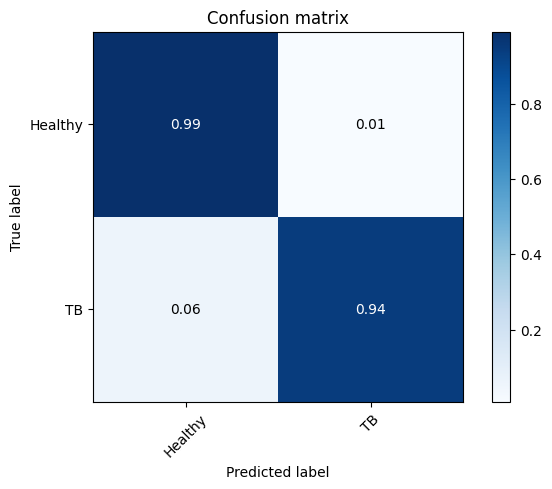

In [29]:
plot_confusion_matrix(model, test_dataloader, device, ['Healthy','TB'], normalize=True)